In [1]:
!pip install nbformat
!pip install chardet

In [2]:
import pandas as pd
import os 
import requests 
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt 
import zipfile
import io
import re

### Download de la bdd parcelles bio 

In [3]:

# Dictionnaire des URLs par année
urls = {
    2022: 'https://www.data.gouv.fr/fr/datasets/r/36314eff-2712-4d6a-b091-7752a5b318bb',
    2021: 'https://www.data.gouv.fr/fr/datasets/r/e6cd3b9f-38e2-47ca-aac6-5acfb9567e01',
    2023: "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29",
}

for year, url_zip in urls.items():
    print(f"\nTraitement de l'année {year}...")

    # Chemin pour stocker temporairement le fichier téléchargé
    file_path = f"data_{year}.zip"

    # Télécharger le fichier
    response = requests.get(url_zip)
    if response.status_code != 200:
        print(f"Erreur lors du téléchargement pour l'année {year}: {response.status_code}")
        continue

    # Enregistrer le fichier localement
    with open(file_path, "wb") as f:
        f.write(response.content)

    # Vérifier si le fichier est un ZIP
    if zipfile.is_zipfile(file_path):
        print(f"Extraction du fichier ZIP pour l'année {year}")
        extract_path = f"data_extracted_{year}"
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        with zipfile.ZipFile(file_path, "r") as zip_ref:
            zip_ref.extractall(extract_path)

        # Afficher tous les fichiers extraits pour diagnostic
        print(f"Fichiers extraits pour {year} :")
        extracted_files = []
        for root, _, files in os.walk(extract_path):
            for file in files:
                extracted_files.append(os.path.join(root, file))
                print(f"- {file}")

        # Lire les fichiers extraits si ce sont des CSV
        for file in extracted_files:
            if file.endswith(".csv"):
                gdf = pd.read_csv(file)
                globals()[f"gdf{year}"] = gdf.drop(columns='geometry', errors='ignore')
                print(f"Aperçu des données pour {year} :")
                print(globals()[f"gdf{year}"].head())
    else:
        print(f"Le fichier pour {year} n'est pas un ZIP.")



Traitement de l'année 2022...
Extraction du fichier ZIP pour l'année 2022
Fichiers extraits pour 2022 :
- rpg-bio-2022-national.gpkg
- ._rpg-bio-2022-national.gpkg

Traitement de l'année 2021...
Extraction du fichier ZIP pour l'année 2021
Fichiers extraits pour 2021 :
- rpg-bio-2021-national.gpkg

Traitement de l'année 2023...
Extraction du fichier ZIP pour l'année 2023
Fichiers extraits pour 2023 :
- rpg-bio-2023-national.shp
- rpg-bio-2023-national.cpg
- rpg-bio-2023-national.gpkg
- rpg-bio-2023-national.shx
- rpg-bio-2023-national.dbf
- rpg-bio-2023-national.prj


In [4]:
# Chemins vers les fichiers extraits
file_2022 = "data_extracted_2022/rpg-bio-2022-national.gpkg"
file_2021 = "data_extracted_2021/rpg-bio-2021-national.gpkg"
file_2023 = "/home/onyxia/work/AgricultureBio_France/data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp"  # Choix du .shp en raison d'un manque de data sur le .gpkg

# Charger les fichiers dans des variables distinctes
gdf2022 = gpd.read_file(file_2022)
gdf2021 = gpd.read_file(file_2021)
gdf2023 = gpd.read_file(file_2023)

# Supprimer la colonne 'geometry' pour chaque GeoDataFrame
gdf2022 = gdf2022.drop(columns=['geometry'])
gdf2021 = gdf2021.drop(columns=['geometry'])
gdf2023 = gdf2023.drop(columns=['geometry'])

# Afficher un aperçu des données après suppression de 'geometry'
print("Aperçu des données pour 2022 (sans geometry) :")
print(gdf2022.head())

print("\nAperçu des données pour 2021 (sans geometry) :")
print(gdf2021.head())

print("\nAperçu des données pour 2023 (sans geometry) :")
print(gdf2023.head())

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/AgricultureBio_France/data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Aperçu des données pour 2022 (sans geometry) :
       gid  millesime code_culture  \
0  4420687       2022          PPH   
1      333       2022          PTR   
2      337       2022          BTH   
3      464       2022          BTH   
4      480       2022          BTH   

                                         lbl_culture           grp_culture  \
0  Prairie permanente - herbe prédominante (resso...  Prairies permanentes   
1         Autre prairie temporaire de 5 ans ou moins  Prairies temporaires   
2                                 Blé tendre d’hiver            Blé tendre   
3                                 Blé tendre d’hiver            Blé tendre   
4                                 Blé tendre d’hiver            Blé tendre   

   surface_ha code_commune_insee             lbl_commune    code_epci  \
0        0.38              38513                Treffort  200030658.0   
1        2.13              01188                  Illiat  200070118.0   
2        6.10              01136  Cr

In [5]:
# Renommer les colonnes dans gdf2023
gdf2023.rename(columns={'code_regio': 'code_region', 'code_depar': 'code_departement'}, inplace=True)

# Vérifier les nouvelles colonnes
print("Colonnes après renommage dans gdf2023 :")
print(gdf2023.columns)


Colonnes après renommage dans gdf2023 :
Index(['gid', 'millesime', 'code_cultu', 'precision_', 'lbl_cultur',
       'grp_cultur', 'surface_ha', 'code_commu', 'lbl_commun', 'code_epci',
       'code_departement', 'code_region', 'zone_geo'],
      dtype='object')


In [6]:
# Récupérer les colonnes sous forme d'ensembles
columns_2022 = set(gdf2022.columns)
columns_2021 = set(gdf2021.columns)
columns_2023 = set(gdf2023.columns)

# Comparer les colonnes entre les trois jeux de données
common_columns = columns_2022 & columns_2021 & columns_2023  # Colonnes communes
unique_2022 = columns_2022 - (columns_2021 | columns_2023)  # Colonnes uniques à 2022
unique_2021 = columns_2021 - (columns_2022 | columns_2023)  # Colonnes uniques à 2021
unique_2023 = columns_2023 - (columns_2021 | columns_2022)  # Colonnes uniques à 2023

# Afficher les résultats
print("Colonnes communes aux trois GeoDataFrames :")
print(common_columns)

print("\nColonnes uniques à 2022 :")
print(unique_2022)

print("\nColonnes uniques à 2021 :")
print(unique_2021)

print("\nColonnes uniques à 2023 :")
print(unique_2023)


Colonnes communes aux trois GeoDataFrames :
{'code_departement', 'code_region', 'code_epci', 'zone_geo', 'millesime', 'surface_ha', 'gid'}

Colonnes uniques à 2022 :
set()

Colonnes uniques à 2021 :
set()

Colonnes uniques à 2023 :
{'grp_cultur', 'lbl_cultur', 'lbl_commun', 'code_cultu', 'precision_', 'code_commu'}


In [8]:
# Ajouter une colonne pour identifier l'année
gdf2021['annee'] = 2021
gdf2022['annee'] = 2022
gdf2023['annee'] = 2023

# Fusionner les trois GeoDataFrames en un seul DataFrame
df_combined = pd.concat([gdf2021, gdf2022, gdf2023], ignore_index=True)

# Vérifier les données fusionnées
print("Aperçu des données fusionnées :")
df_combined.head()

Aperçu des données fusionnées :


,gid,millesime,code_culture,lbl_culture,grp_culture,surface_ha,code_commune_insee,lbl_commune,code_epci,code_departement,code_region,zone_geo,annee,code_cultu,precision_,lbl_cultur,grp_cultur,code_commu,lbl_commun
0,261,2021,BTP,Blé tendre de printemps,Blé tendre,10.19,01276,Niévroz,240100610.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
1,263,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.53,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
2,267,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,7.01,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
3,268,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.37,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
4,274,2021,SOG,Sorgho,Autres céréales,0.59,01204,Le Poizat-Lalleyriat,200042935.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN


### Traitement de la BDD pour achat de pesticide

In [9]:
# Liste des URLs des fichiers ZIP
urls_zip = {
    "2017": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip",
    "2018": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip",
    "2019": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip",
    "2020": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip",
    "2021": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip",
    "2022": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip"
}

# Dossier où seront stockés les fichiers CSV sélectionnés
output_dir = "dossier_Achats_pesticides_selected"
os.makedirs(output_dir, exist_ok=True)

# Modèle de nom de fichier cible (expression régulière)
file_pattern = r"BNVD_TRACABILITE_\d+_ACHAT_DPT_SUBSTANCE_(\d{4})\.csv"

# Boucle pour traiter chaque fichier ZIP
for year, url in urls_zip.items():
    print(f"--- Année {year} : Récupération des données depuis {url} ---")
    try:
        # Télécharger le fichier ZIP en mémoire
        response = requests.get(url)
        response.raise_for_status()
        
        # Ouvrir le fichier ZIP en mémoire
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Filtrer pour sélectionner uniquement le fichier correspondant au modèle
            csv_files = [name for name in z.namelist() if re.search(file_pattern, name)]
            if csv_files:
                target_file = csv_files[0]  # Sélectionner le fichier correspondant
                print(f"Fichier CSV sélectionné pour {year} : {target_file}")
                
                # Construire le chemin pour sauvegarder le fichier dans le répertoire final
                output_path = os.path.join(output_dir, f"achats_pesticides_{year}.csv")
                
                # Extraire et sauvegarder le fichier CSV directement
                with z.open(target_file) as f:
                    df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")
                    df.to_csv(output_path, index=False, sep=";")
                    print(f"Fichier pour {year} sauvegardé : {output_path}")
            else:
                print(f"Aucun fichier correspondant trouvé dans l'archive ZIP pour {year}")
    except Exception as e:
        print(f"Erreur pour l'année {year} : {e}")

print("\n--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---")


--- Année 2017 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip ---
Fichier CSV sélectionné pour 2017 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2017.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2017 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
--- Année 2018 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip ---
Fichier CSV sélectionné pour 2018 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2018.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2018 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2018.csv
--- Année 2019 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip ---
Fichier CSV sélectionné pour 2019 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2019.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2019 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
--- Année 2020 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip ---
Fichier CSV sélectionné pour 2020 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2020.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2020 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
--- Année 2021 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip ---
Fichier CSV sélectionné pour 2021 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2021.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2021 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2021.csv
--- Année 2022 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip ---
Fichier CSV sélectionné pour 2022 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2022.csv


/tmp/ipykernel_118170/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2022 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2022.csv

--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---


In [10]:
# Répertoire contenant les fichiers CSV
input_dir = "/home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected"

# Liste des années à traiter
annees = range(2017, 2023)

# Dictionnaire pour stocker les DataFrames par année
dataframes = {}

# Boucle pour lire les fichiers de chaque année
for annee in annees:
    file_path = os.path.join(input_dir, f"achats_pesticides_{annee}.csv")
    try:
        print(f"Lecture du fichier : {file_path}")
        df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
        dataframes[annee] = df  # Stocker le DataFrame dans le dictionnaire
        print(f"Année {annee} chargée avec succès. Nombre de lignes : {len(df)}")
    except Exception as e:
        print(f"Erreur pour l'année {annee} : {e}")

# Exemple : Accéder aux données pour une année spécifique
print("\nAperçu des données de 2017 :")
dataframes[2017].head()


Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
Année 2017 chargée avec succès. Nombre de lignes : 127088
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2018.csv


/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2018 chargée avec succès. Nombre de lignes : 127328
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
Année 2019 chargée avec succès. Nombre de lignes : 112807
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
Année 2020 chargée avec succès. Nombre de lignes : 111224
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2021.csv


/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2021 chargée avec succès. Nombre de lignes : 109573
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2022.csv
Année 2022 chargée avec succès. Nombre de lignes : 106661

Aperçu des données de 2017 :


/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_118170/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


,annee,code_departement,departement,amm,substance,cas,quantite_substance,classification,classification_mention,achat_etranger
0,2017,00,INDETERMINE,2179999,mesosulfuron-methyl,208465-21-8,2.77500,N Organique,NaN,Non
1,2017,00,INDETERMINE,2010618,cuivre du sulfate de cuivre,8011-63-0,247.02400,N minéral,NaN,Non
2,2017,00,INDETERMINE,2010628,trifloxystrobine,141517-21-7,1.00000,N Organique,NaN,Non
3,2017,00,INDETERMINE,2010637,"2,4-d",94-75-7,0.26040,N Organique,NaN,Non
4,2017,00,INDETERMINE,2010637,triclopyr,55335-06-3,0.29008,N Organique,NaN,Non


In [11]:
# Variables à extraire
variables = ["code_departement", "departement"]

# Créer des ensembles pour stocker les valeurs uniques
codes_departements = set()
noms_departements = set()

# Parcourir les DataFrames par année
for annee, df in dataframes.items():
    print(f"Traitement des données pour l'année {annee}")
    # Ajouter les valeurs uniques pour chaque variable, si les colonnes existent
    if "code_departement" in df.columns:
        codes_departements.update(df["code_departement"].dropna().astype(str).unique())
    if "departement" in df.columns:
        noms_departements.update(df["departement"].dropna().astype(str).unique())

# Convertir en liste pour affichage ordonné
codes_departements = sorted(list(codes_departements))
noms_departements = sorted(list(noms_departements))

# Afficher les résultats
print("\nToutes les valeurs uniques de 'code_departement' :")
print(codes_departements)

print("\nToutes les valeurs uniques de 'departement' :")
print(noms_departements)


Traitement des données pour l'année 2017
Traitement des données pour l'année 2018
Traitement des données pour l'année 2019
Traitement des données pour l'année 2020
Traitement des données pour l'année 2021
Traitement des données pour l'année 2022

Toutes les valeurs uniques de 'code_departement' :
['0', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '971', '972', '973', '974', '976']

Toutes les valeurs uniques de 'departement' :
['AIN', 'AISNE', 'ALLI

In [12]:
# Parcourir les DataFrames et supprimer les lignes avec code_departement == "00"
for annee, df in dataframes.items():
    if "code_departement" in df.columns:
        # Filtrer les lignes où code_departement est différent de "00"
        initial_rows = len(df)
        dataframes[annee] = df[df["code_departement"].astype(str) != "00"].reset_index(drop=True)
        final_rows = len(dataframes[annee])
        
        print(f"Année {annee} : {initial_rows - final_rows} lignes supprimées. Nouveau total : {final_rows} lignes.")
    else:
        print(f"Année {annee} : Colonne 'code_departement' non trouvée, aucune modification effectuée.")

print("\nSuppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.")


Année 2017 : 722 lignes supprimées. Nouveau total : 126366 lignes.
Année 2018 : 888 lignes supprimées. Nouveau total : 126440 lignes.
Année 2019 : 526 lignes supprimées. Nouveau total : 112281 lignes.
Année 2020 : 592 lignes supprimées. Nouveau total : 110632 lignes.
Année 2021 : 664 lignes supprimées. Nouveau total : 108909 lignes.
Année 2022 : 542 lignes supprimées. Nouveau total : 106119 lignes.

Suppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.


In [13]:
# Créer un DataFrame global pour stocker les agrégations par année et département
evolution_df = pd.DataFrame()

# Agréger les données par département et année
for annee, df in dataframes.items():
    if "code_departement" in df.columns and "quantite_substance" in df.columns:
        aggregated = df.groupby("code_departement")["quantite_substance"].sum().reset_index()
        aggregated["annee"] = annee
        evolution_df = pd.concat([evolution_df, aggregated], ignore_index=True)

# Pivot pour obtenir une colonne par année
pivot_df = evolution_df.pivot(index="code_departement", columns="annee", values="quantite_substance").fillna(0)

# Calculer les variations entre les années successives
variations_df = pivot_df.diff(axis=1).dropna(axis=1)  # Calcul des différences entre colonnes successives

# Affichage des variations
print("Variations des quantités de pesticides par département :")
print(variations_df.head())

Variations des quantités de pesticides par département :
annee                      2018          2019           2020           2021  \
code_departement                                                              
0                 285080.318476 -3.916480e+05 -720722.297263  167859.131997   
1                 187946.790448 -7.966968e+04   40081.433510    9155.048167   
2                      0.000000  0.000000e+00  608205.719704  -48738.487450   
50               -296558.647488 -3.400483e+05       0.000000       0.000000   
51                180122.382853 -2.807595e+06       0.000000       0.000000   

annee                      2022  
code_departement                 
0                -275900.715528  
1                 136470.050557  
2                -316019.858914  
50                     0.000000  
51                     0.000000  


### Travail sur les deux DF obtenus et merge des deux bases de données 

In [14]:
print("Colonnes dans variations_df :")
print(variations_df.columns)

print("\nColonnes dans df_combined :")
print(df_combined.columns)


Colonnes dans variations_df :
Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='annee')

Colonnes dans df_combined :
Index(['gid', 'millesime', 'code_culture', 'lbl_culture', 'grp_culture',
       'surface_ha', 'code_commune_insee', 'lbl_commune', 'code_epci',
       'code_departement', 'code_region', 'zone_geo', 'annee', 'code_cultu',
       'precision_', 'lbl_cultur', 'grp_cultur', 'code_commu', 'lbl_commun'],
      dtype='object')


In [15]:
# Réinitialiser l'index pour récupérer 'code_departement' comme colonne
variations_df = variations_df.reset_index()

print("Colonnes après réinitialisation de l'index :")
print(variations_df.columns)


Colonnes après réinitialisation de l'index :
Index(['code_departement', 2018, 2019, 2020, 2021, 2022], dtype='object', name='annee')


#### Harmanisation des types des deux bases de données + fusion 


In [17]:
variations_df['code_departement'] = variations_df['code_departement'].astype(str)
df_combined['code_departement'] = df_combined['code_departement'].astype(str)
df_combined = df_combined.merge(
    variations_df,
    on='code_departement',
    how='left'  # Garder toutes les lignes de df_combined
)

df_combined.head()


,gid,millesime,code_culture,lbl_culture,grp_culture,surface_ha,code_commune_insee,lbl_commune,code_epci,code_departement,...,2018_x,2019_x,2020_x,2021_x,2022_x,2018_y,2019_y,2020_y,2021_y,2022_y
0,261,2021,BTP,Blé tendre de printemps,Blé tendre,10.19,01276,Niévroz,240100610.0,01,...,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
1,263,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.53,01187,Haut Valromey,200040350.0,01,...,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
2,267,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,7.01,01187,Haut Valromey,200040350.0,01,...,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
3,268,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.37,01187,Haut Valromey,200040350.0,01,...,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
4,274,2021,SOG,Sorgho,Autres céréales,0.59,01204,Le Poizat-Lalleyriat,200042935.0,01,...,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894


In [18]:
df_combined.columns

Index(['gid', 'millesime', 'code_culture', 'lbl_culture', 'grp_culture',
       'surface_ha', 'code_commune_insee', 'lbl_commune', 'code_epci',
       'code_departement', 'code_region', 'zone_geo', 'annee', 'code_cultu',
       'precision_', 'lbl_cultur', 'grp_cultur', 'code_commu', 'lbl_commun',
       '2018_x', '2019_x', '2020_x', '2021_x', '2022_x', '2018_y', '2019_y',
       '2020_y', '2021_y', '2022_y'],
      dtype='object')

In [31]:
# Compter les occurrences de chaque valeur dans 'grp_culture'
if 'grp_culture' in df_combined.columns:
    value_counts = df_combined['grp_culture'].value_counts()
    print("Fréquence des valeurs dans 'grp_culture' :")
    print(value_counts)
else:
    print("La colonne 'grp_culture' n'existe pas dans le DataFrame.")



Fréquence des valeurs dans 'grp_culture' :
grp_culture
Prairies permanentes                     844089
Fourrage                                 284522
Prairies temporaires                     268248
Vignes                                   250286
Autres céréales                          164891
Divers                                   111867
Estives et landes                        106277
Blé tendre                               106245
Légumes ou fleurs                         92866
Vergers                                   61965
Maïs grain et ensilage                    59026
Gel (surfaces gelées sans production)     47491
Protéagineux                              41300
Orge                                      38762
Tournesol                                 33215
Autres cultures industrielles             28794
Fruits à coque                            26830
Autres oléagineux                         26241
Légumineuses à grains                     13996
Oliviers                         

In [24]:
# Liste des départements métropolitains
metropolitan_departments = [
    '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
    '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27',
    '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
    '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
    '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
    '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79',
    '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92',
    '93', '94', '95'
]

# Convertir les codes départements en chaîne pour les comparer
df_combined['code_departement'] = df_combined['code_departement'].astype(str)

# Filtrer pour ne conserver que les départements métropolitains
df_combined = df_combined[df_combined['code_departement'].isin(metropolitan_departments)]

print("Données filtrées pour les départements métropolitains :")
print(df_combined['code_departement'].unique())


Données filtrées pour les départements métropolitains :
['01' '54' '04' '57' '38' '59' '73' '67' '11' '24' '02' '51' '03' '23'
 '83' '07' '08' '05' '84' '77' '26' '43' '13' '63' '71' '30' '37' '47'
 '46' '40' '09' '31' '15' '32' '21' '66' '65' '85' '81' '10' '17' '06'
 '55' '22' '12' '52' '48' '89' '34' '14' '61' '27' '16' '18' '78' '41'
 '58' '87' '70' '50' '19' '64' '28' '29' '86' '79' '56' '69' '62' '33'
 '25' '39' '76' '72' '82' '42' '44' '45' '35' '36' '49' '53' '88' '68'
 '60' '80' '74' '90' '91' '93' '94' '95']


### Début du ML 

## RANDOM FOREST REGRESSOR

In [21]:
# import des bibliothèques nécessaires à l'exécution du ML
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [25]:
# Définir la cible (surface agricole biologique)
target = 'surface_ha'

# Colonnes explicatives (features)
features = ['code_region', 'zone_geo', '2018_x', '2019_x', '2020_x', '2021_x', '2022_x']

# Créer les matrices X (caractéristiques) et y (cible)
X = df_combined[features]
y = df_combined[target]

# Remplacer les valeurs manquantes
X = X.fillna(0)
y = y.fillna(0)

# Vérifier les types de données des colonnes
print("Types de données dans X avant nettoyage :")
print(X.dtypes)

# Identifier les colonnes non numériques
for col in X.select_dtypes(include=['object']).columns:
    print(f"Valeurs uniques dans {col} :")
    print(X[col].unique())

# Gestion des colonnes non numériques
if 'zone_geo' in X.columns:
    # Exemple : Remplacement de 'France mét.' ou autre valeur par un nombre
    X['zone_geo'] = X['zone_geo'].replace('France mét.', 1).astype(int)

if 'code_region' in X.columns:
    # Conversion en type entier (si applicable)
    X['code_region'] = X['code_region'].astype(int)

# Vérifier les types de données après nettoyage
print("Types de données dans X après nettoyage :")
print(X.dtypes)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



Types de données dans X avant nettoyage :
code_region    float64
zone_geo        object
2018_x         float64
2019_x         float64
2020_x         float64
2021_x         float64
2022_x         float64
dtype: object
Valeurs uniques dans zone_geo :
['France mét.']


/tmp/ipykernel_118170/1200150972.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['zone_geo'] = X['zone_geo'].replace('France mét.', 1).astype(int)


Types de données dans X après nettoyage :
code_region      int64
zone_geo         int64
2018_x         float64
2019_x         float64
2020_x         float64
2021_x         float64
2022_x         float64
dtype: object


In [26]:
# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [27]:
# Faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 33.66
R² Score: 0.02


Importance des caractéristiques :
       Feature  Importance
0  code_region    0.337596
6       2022_x    0.208137
5       2021_x    0.175081
4       2020_x    0.127265
2       2018_x    0.101088
3       2019_x    0.050834
1     zone_geo    0.000000


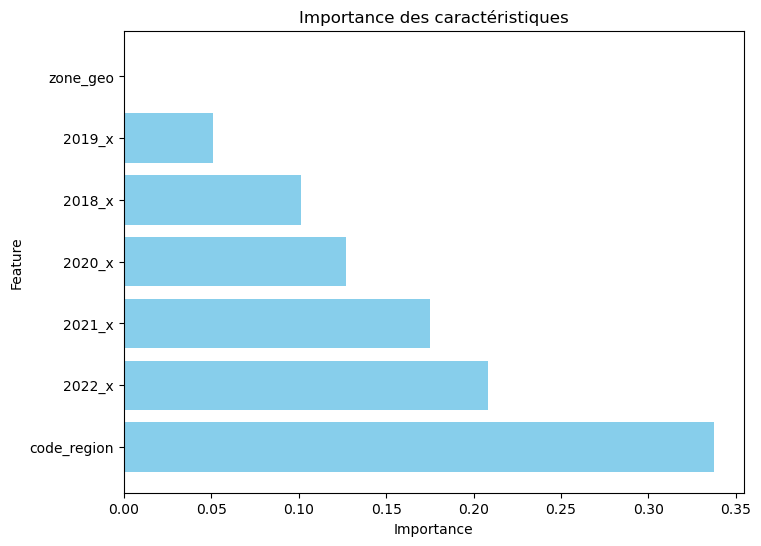

In [28]:
# Importance des caractéristiques
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des caractéristiques :")
print(feature_importances)

# Visualisation des importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des caractéristiques')
plt.show()


## Autre approche le *CLUSTERING* avec la méthode des k-means

In [54]:
# Vérifier les doublons par code_departement
duplicated_departements = df_combined[df_combined.duplicated(subset=['code_departement'], keep=False)]

print("Départements en doublon :")
print(duplicated_departements)


Départements en doublon :
             gid  millesime code_culture  \
0            261       2021          BTP   
1            263       2021          PPH   
2            267       2021          PPH   
3            268       2021          PPH   
4            274       2021          SOG   
...          ...        ...          ...   
4100430  1058110       2023          NaN   
4100431  1057699       2023          NaN   
4100432  1057706       2023          NaN   
4100433  1057715       2023          NaN   
4100434  1063879       2023          NaN   

                                               lbl_culture  \
0                                  Blé tendre de printemps   
1        Prairie permanente - herbe prédominante (resso...   
2        Prairie permanente - herbe prédominante (resso...   
3        Prairie permanente - herbe prédominante (resso...   
4                                                   Sorgho   
...                                                    ...   
4100430    

In [55]:
# Agréger les données par département
df_aggregated = df_combined.groupby('code_departement', as_index=False).agg({
    'surface_ha': 'sum',  # Exemple : somme des surfaces agricoles
    '2018_x': 'mean',     # Moyenne des variations de pesticides
    '2019_x': 'mean',
    '2020_x': 'mean',
    '2021_x': 'mean',
    '2022_x': 'mean',
    # Ajouter d'autres colonnes numériques ici
    'zone_geo': 'first',  # Garder la première valeur (si non numérique)
   
})

# Vérifier les départements uniques après agrégation
print(df_aggregated['code_departement'].nunique())


92


In [57]:
# Calculer la fréquence des cultures par département
grp_culture_frequency = df_combined.groupby(['code_departement', 'grp_culture']).size().unstack(fill_value=0)

# Fusionner avec le DataFrame agrégé
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left')

df_aggregated.head()

,code_departement,surface_ha,2018_x,2019_x,2020_x,2021_x,2022_x,zone_geo,Autres cultures industrielles_x,Autres céréales_x,...,Oliviers_y,Orge_y,Plantes à fibres_y,Prairies permanentes_y,Prairies temporaires_y,Protéagineux_y,Riz_y,Tournesol_y,Vergers_y,Vignes_y
0,01,62679.79,-161053.286170,-64801.027366,49485.035649,3580.550909,-160592.558940,France mét.,56,947,...,0,329,5,7468,1463,76,1,163,150,540
1,02,33632.30,398230.462851,-855026.230681,-214100.814510,289657.273504,226889.055315,France mét.,41,578,...,0,135,12,2220,504,143,0,39,197,441
2,03,68748.77,7512.571321,-116099.470325,66417.453042,22191.222494,9142.918036,France mét.,54,1207,...,0,105,11,6016,1906,212,0,115,171,127
3,04,152819.96,71175.303742,-52219.272804,4597.614843,-42276.536929,24650.676254,France mét.,2016,1571,...,1320,517,13,7070,1397,55,0,128,896,362
4,05,113855.59,33423.736388,-19639.647290,7983.462295,-34075.109647,48929.685145,France mét.,392,1731,...,8,903,13,10249,1397,20,0,20,854,353


In [62]:
# Liste complète des cultures
all_cultures = [
    'Autres cultures industrielles', 'Autres céréales', 'Autres oléagineux', 
    'Blé tendre', 'Colza', 'Divers', 'Estives et landes', 'Fourrage', 
    'Fruits à coque', 'Gel (surfaces gelées sans production)', 'Légumes ou fleurs', 
    'Légumineuses à grains', 'Maïs grain et ensilage', 'Oliviers', 'Orge', 
    'Plantes à fibres', 'Prairies permanentes', 'Prairies temporaires', 
    'Protéagineux', 'Riz', 'Tournesol', 'Vergers', 'Vignes'
]
# Calcul des fréquences
grp_culture_frequency = df_combined.groupby(['code_departement', 'grp_culture']).size().unstack(fill_value=0)

# Ajouter les colonnes manquantes
for culture in all_cultures:
    if culture not in grp_culture_frequency.columns:
        grp_culture_frequency[culture] = 0

grp_culture_frequency.head()


grp_culture,Autres cultures industrielles,Autres céréales,Autres oléagineux,Blé tendre,Colza,Divers,Estives et landes,Fourrage,Fruits à coque,Gel (surfaces gelées sans production),...,Oliviers,Orge,Plantes à fibres,Prairies permanentes,Prairies temporaires,Protéagineux,Riz,Tournesol,Vergers,Vignes
code_departement,,,,,,,,,,,,,,,,,,,,,
01,56,947,549,732,73,248,191,1207,12,312,...,0,329,5,7468,1463,76,1,163,150,540
02,41,578,21,438,23,422,40,730,38,259,...,0,135,12,2220,504,143,0,39,197,441
03,54,1207,31,510,6,470,184,962,25,121,...,0,105,11,6016,1906,212,0,115,171,127
04,2016,1571,78,909,0,1631,7149,5034,75,366,...,1320,517,13,7070,1397,55,0,128,896,362
05,392,1731,28,1392,4,948,7367,6024,234,28,...,8,903,13,10249,1397,20,0,20,854,353


In [66]:
# Vérifier les colonnes communes entre df_aggregated et grp_culture_frequency
common_columns = set(df_aggregated.columns).intersection(set(grp_culture_frequency.columns))
print("Colonnes communes :", common_columns)
# Renommer les colonnes de grp_culture_frequency avec un préfixe
grp_culture_frequency = grp_culture_frequency.add_prefix('culture_')

print("Nouvelles colonnes dans grp_culture_frequency :")
print(grp_culture_frequency.columns)


Colonnes communes : {'Prairies temporaires', 'Vignes', 'Blé tendre', 'Divers', 'Tournesol', 'Fruits à coque', 'Autres oléagineux', 'Légumineuses à grains', 'Légumes ou fleurs', 'Maïs grain et ensilage', 'Gel (surfaces gelées sans production)', 'Oliviers', 'Vergers', 'Riz', 'Protéagineux', 'Autres cultures industrielles', 'Estives et landes', 'Autres céréales', 'Orge', 'Colza', 'Fourrage', 'Prairies permanentes', 'Plantes à fibres'}
Nouvelles colonnes dans grp_culture_frequency :
Index(['culture_Autres cultures industrielles', 'culture_Autres céréales',
       'culture_Autres oléagineux', 'culture_Blé tendre', 'culture_Colza',
       'culture_Divers', 'culture_Estives et landes', 'culture_Fourrage',
       'culture_Fruits à coque',
       'culture_Gel (surfaces gelées sans production)',
       'culture_Légumes ou fleurs', 'culture_Légumineuses à grains',
       'culture_Maïs grain et ensilage', 'culture_Oliviers', 'culture_Orge',
       'culture_Plantes à fibres', 'culture_Prairies perm

In [68]:
# Fusionner les données agrégées avec les fréquences des cultures
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left')

# Remplacer les NaN par 0 après la fusion
df_aggregated.fillna(0, inplace=True)

print("Aperçu des données après fusion :")
df_aggregated.head()



Aperçu des données après fusion :


,code_departement,surface_ha,2018_x,2019_x,2020_x,2021_x,2022_x,zone_geo,Autres cultures industrielles_x,Autres céréales_x,...,culture_Oliviers_y,culture_Orge_y,culture_Plantes à fibres_y,culture_Prairies permanentes_y,culture_Prairies temporaires_y,culture_Protéagineux_y,culture_Riz_y,culture_Tournesol_y,culture_Vergers_y,culture_Vignes_y
0,01,62679.79,-161053.286170,-64801.027366,49485.035649,3580.550909,-160592.558940,France mét.,56,947,...,0,329,5,7468,1463,76,1,163,150,540
1,02,33632.30,398230.462851,-855026.230681,-214100.814510,289657.273504,226889.055315,France mét.,41,578,...,0,135,12,2220,504,143,0,39,197,441
2,03,68748.77,7512.571321,-116099.470325,66417.453042,22191.222494,9142.918036,France mét.,54,1207,...,0,105,11,6016,1906,212,0,115,171,127
3,04,152819.96,71175.303742,-52219.272804,4597.614843,-42276.536929,24650.676254,France mét.,2016,1571,...,1320,517,13,7070,1397,55,0,128,896,362
4,05,113855.59,33423.736388,-19639.647290,7983.462295,-34075.109647,48929.685145,France mét.,392,1731,...,8,903,13,10249,1397,20,0,20,854,353


In [72]:
# Fusionner les données agrégées avec les fréquences des cultures
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left')

# Remplacer les valeurs NaN par 0 après la fusion
df_aggregated.fillna(0, inplace=True)


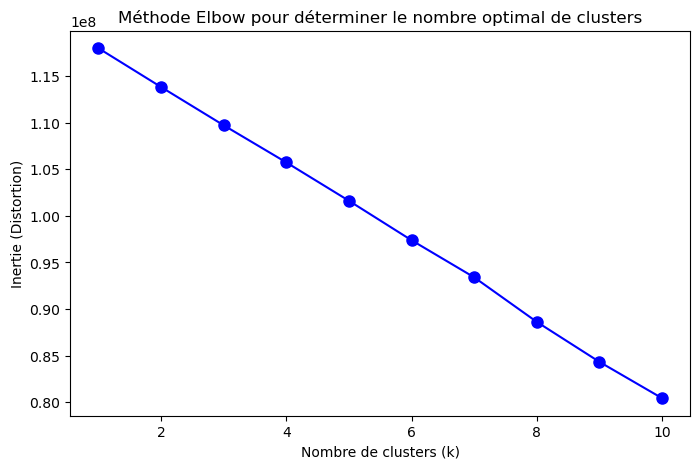

In [69]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculer l'inertie (distortion) pour différents nombres de clusters
inertia = []
K_range = range(1, 11)  # Tester pour k de 1 à 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

# Tracer le graphique de la méthode Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Distortion)')
plt.title('Méthode Elbow pour déterminer le nombre optimal de clusters')
plt.show()





Inertie décroissante ce qui est normal en raison du fait que plus le nombre de cluster plus le jeu de données est divisé. Cependant pas de 'elbow' de visible qui change brusquement la courbe. On utilise le score de silhouette pour déterminer k dans le cadre de notre méthode des k-means


In [ ]:
# Échantillonnage aléatoire (par exemple, 20% des données)
#sampled_data = clustering_data_scaled[np.random.choice(clustering_data_scaled.shape[0], size=int(0.2 * clustering_data_scaled.shape[0]), replace=False)]

# Calcul du score de silhouette sur les données échantillonnées
#silhouette_scores = []
#for k in range(2, 11):
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #clusters = kmeans.fit_predict(sampled_data)
    #score = silhouette_score(sampled_data, clusters)
   # silhouette_scores.append(score)

# Tracer le score de silhouette
#plt.figure(figsize=(8, 5))
#plt.plot(range(2, 11), silhouette_scores, 'bo-', markersize=8)
#plt.xlabel('Nombre de clusters (k)')
#plt.ylabel('Score de silhouette (échantillonnage)')
#plt.title('Score de silhouette avec échantillonnage')
#plt.show()


Malheureusement le méthode du score de silhouette prend beaucoup de temps à s'exécuter. Nous décidons de prendre arbitrairement le nombre 5 pour k et voir avec la visualisation graphique si c'est un nombre satisfaisant dans notre approche 

In [78]:
# Vérifier les colonnes sélectionnées pour le clustering
clustering_features = ['surface_ha', '2018_x', '2019_x', '2020_x', '2021_x', '2022_x'] + list(grp_culture_frequency.columns)

print("Colonnes utilisées pour le clustering :")
print(clustering_features)

# Normaliser les données
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(df_aggregated[clustering_features])

# Appliquer K-Means avec K=7
kmeans = KMeans(n_clusters=7, random_state=42)
df_aggregated['cluster'] = kmeans.fit_predict(clustering_data_scaled)

print("Clusters assignés avec succès !")


Colonnes utilisées pour le clustering :
['surface_ha', '2018_x', '2019_x', '2020_x', '2021_x', '2022_x', 'culture_Autres cultures industrielles', 'culture_Autres céréales', 'culture_Autres oléagineux', 'culture_Blé tendre', 'culture_Colza', 'culture_Divers', 'culture_Estives et landes', 'culture_Fourrage', 'culture_Fruits à coque', 'culture_Gel (surfaces gelées sans production)', 'culture_Légumes ou fleurs', 'culture_Légumineuses à grains', 'culture_Maïs grain et ensilage', 'culture_Oliviers', 'culture_Orge', 'culture_Plantes à fibres', 'culture_Prairies permanentes', 'culture_Prairies temporaires', 'culture_Protéagineux', 'culture_Riz', 'culture_Tournesol', 'culture_Vergers', 'culture_Vignes']
Clusters assignés avec succès !


In [80]:
# Compter les départements dans chaque cluster
print("Distribution des départements par cluster :")
print(df_aggregated['cluster'].value_counts())



Distribution des départements par cluster :
cluster
0    50
3    14
4     9
2     8
5     7
1     3
6     1
Name: count, dtype: int64


In [92]:
# Moyennes des caractéristiques par cluster
cluster_analysis = df_aggregated.groupby('cluster')[clustering_features].mean()

print("Analyse des moyennes par cluster :")
print(cluster_analysis)





Analyse des moyennes par cluster :
            surface_ha         2018_x        2019_x         2020_x  \
cluster                                                              
0         59353.732800   70108.868274 -1.817278e+05   71542.676513   
1        414747.720000  -22435.725983 -9.429872e+04   28921.154147   
2         57435.343750  698107.042504 -1.008621e+06  296046.512525   
3        218038.236429   70286.632213 -2.062410e+05   93391.793406   
4        133747.281111   98513.745106 -3.177854e+05  175012.858658   
5        160535.008571   91599.669344 -3.243959e+05   57329.486398   
6        340301.550000  634894.767206 -9.892214e+05  406484.110946   

                2021_x         2022_x  culture_Autres cultures industrielles  \
cluster                                                                        
0         30008.705951    6723.746913                             100.680000   
1         30573.328415   -6543.733984                             480.000000   
2        16619

In [52]:
#Chargement de la carte des départements
dept_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
gdf_departements = gpd.read_file(dept_url)

/tmp/ipykernel_118170/3297460233.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', num_clusters)  # Par exemple, 'tab10' pour 10 couleurs


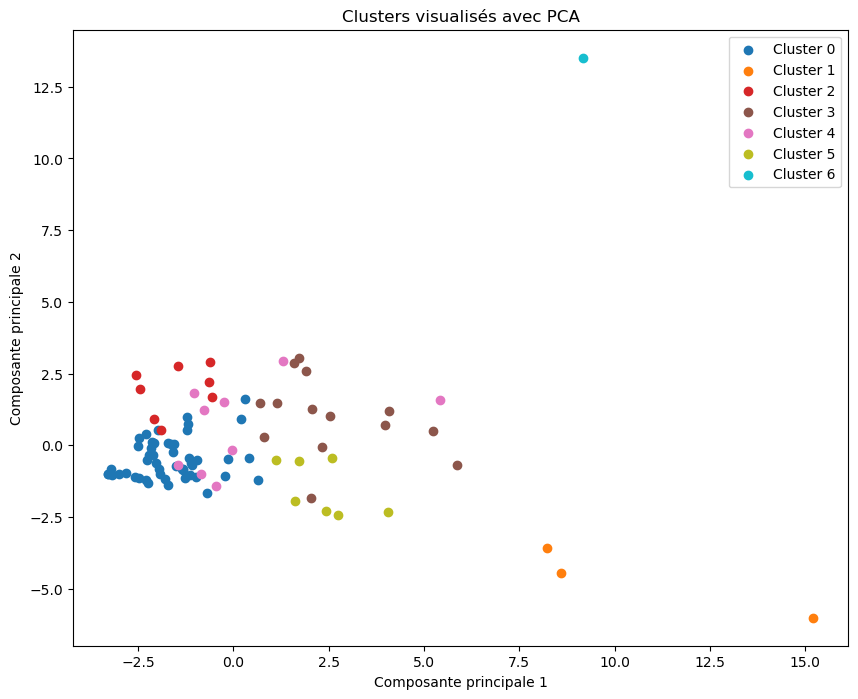

In [84]:
import matplotlib.cm as cm

# Générer une colormap dynamique
num_clusters = df_aggregated['cluster'].nunique()
colormap = cm.get_cmap('tab10', num_clusters)  # Par exemple, 'tab10' pour 10 couleurs

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):  # Assurez-vous que cluster_id correspond à la plage réelle
    cluster_points = reduced_data[df_aggregated['cluster'] == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", color=colormap(cluster_id))

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Clusters visualisés avec PCA")
plt.legend()
plt.show()



In [85]:
# Obtenir les poids des variables dans les composantes principales
pca_components = pd.DataFrame(pca.components_, columns=clustering_features, index=['PC1', 'PC2'])
print("Contributions des variables dans les composantes principales :")
print(pca_components)


Contributions des variables dans les composantes principales :
     surface_ha    2018_x    2019_x    2020_x    2021_x    2022_x  \
PC1    0.298752 -0.034825  0.017361 -0.011391 -0.027258 -0.019931   
PC2   -0.003764  0.259411 -0.275618  0.245772  0.017165 -0.015019   

     culture_Autres cultures industrielles  culture_Autres céréales  \
PC1                               0.099441                 0.295016   
PC2                               0.074731                -0.089510   

     culture_Autres oléagineux  culture_Blé tendre  ...  culture_Oliviers  \
PC1                   0.124014            0.253463  ...         -0.005029   
PC2                   0.357833            0.165171  ...          0.084862   

     culture_Orge  culture_Plantes à fibres  culture_Prairies permanentes  \
PC1      0.285918                  0.200859                      0.254738   
PC2     -0.029843                 -0.098796                     -0.208304   

     culture_Prairies temporaires  culture_Protéagi

In [86]:
for cluster_id in df_aggregated['cluster'].unique():
    print(f"Départements dans le Cluster {cluster_id} :")
    print(df_aggregated[df_aggregated['cluster'] == cluster_id]['code_departement'].values)


Départements dans le Cluster 0 :
['01' '02' '03' '05' '06' '08' '09' '10' '14' '15' '18' '19' '23' '25'
 '27' '36' '37' '38' '39' '40' '41' '42' '43' '45' '46' '61' '63' '64'
 '65' '67' '68' '69' '70' '71' '72' '73' '74' '76' '77' '78' '81' '82'
 '83' '87' '88' '90' '91' '93' '94' '95']
Départements dans le Cluster 4 :
['04' '07' '11' '13' '26' '30' '34' '48' '66']
Départements dans le Cluster 3 :
['12' '21' '24' '31' '47' '51' '52' '54' '55' '57' '58' '79' '86' '89']
Départements dans le Cluster 2 :
['16' '17' '28' '33' '60' '62' '80' '84']
Départements dans le Cluster 5 :
['22' '29' '35' '44' '49' '59' '85']
Départements dans le Cluster 6 :
['32']
Départements dans le Cluster 1 :
['50' '53' '56']


In [87]:
cluster_analysis = df_aggregated.groupby('cluster')[clustering_features].mean()
print(cluster_analysis)


            surface_ha         2018_x        2019_x         2020_x  \
cluster                                                              
0         59353.732800   70108.868274 -1.817278e+05   71542.676513   
1        414747.720000  -22435.725983 -9.429872e+04   28921.154147   
2         57435.343750  698107.042504 -1.008621e+06  296046.512525   
3        218038.236429   70286.632213 -2.062410e+05   93391.793406   
4        133747.281111   98513.745106 -3.177854e+05  175012.858658   
5        160535.008571   91599.669344 -3.243959e+05   57329.486398   
6        340301.550000  634894.767206 -9.892214e+05  406484.110946   

                2021_x         2022_x  culture_Autres cultures industrielles  \
cluster                                                                        
0         30008.705951    6723.746913                             100.680000   
1         30573.328415   -6543.733984                             480.000000   
2        166198.303360 -104538.275297            

In [88]:
# Fusionner les données des clusters avec les départements
gdf_map = gdf_departements.merge(df_aggregated, left_on='code', right_on='code_departement', how='inner')

print("Aperçu des données fusionnées :")
print(gdf_map.head())


Aperçu des données fusionnées :
  code                      nom  \
0   01                      Ain   
1   02                    Aisne   
2   03                   Allier   
3   04  Alpes-de-Haute-Provence   
4   05             Hautes-Alpes   

                                            geometry code_departement  \
0  POLYGON ((4.78021 46.17668, 4.79458 46.21832, ...               01   
1  POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4...               02   
2  POLYGON ((3.03207 46.79491, 3.04907 46.75808, ...               03   
3  POLYGON ((5.67604 44.19143, 5.69209 44.18648, ...               04   
4  POLYGON ((6.26057 45.12685, 6.29922 45.10855, ...               05   

   surface_ha         2018_x         2019_x         2020_x         2021_x  \
0    62679.79 -161053.286170  -64801.027366   49485.035649    3580.550909   
1    33632.30  398230.462851 -855026.230681 -214100.814510  289657.273504   
2    68748.77    7512.571321 -116099.470325   66417.453042   22191.222494   
3   152819

/tmp/ipykernel_118170/1133700105.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', df_aggregated['cluster'].nunique())


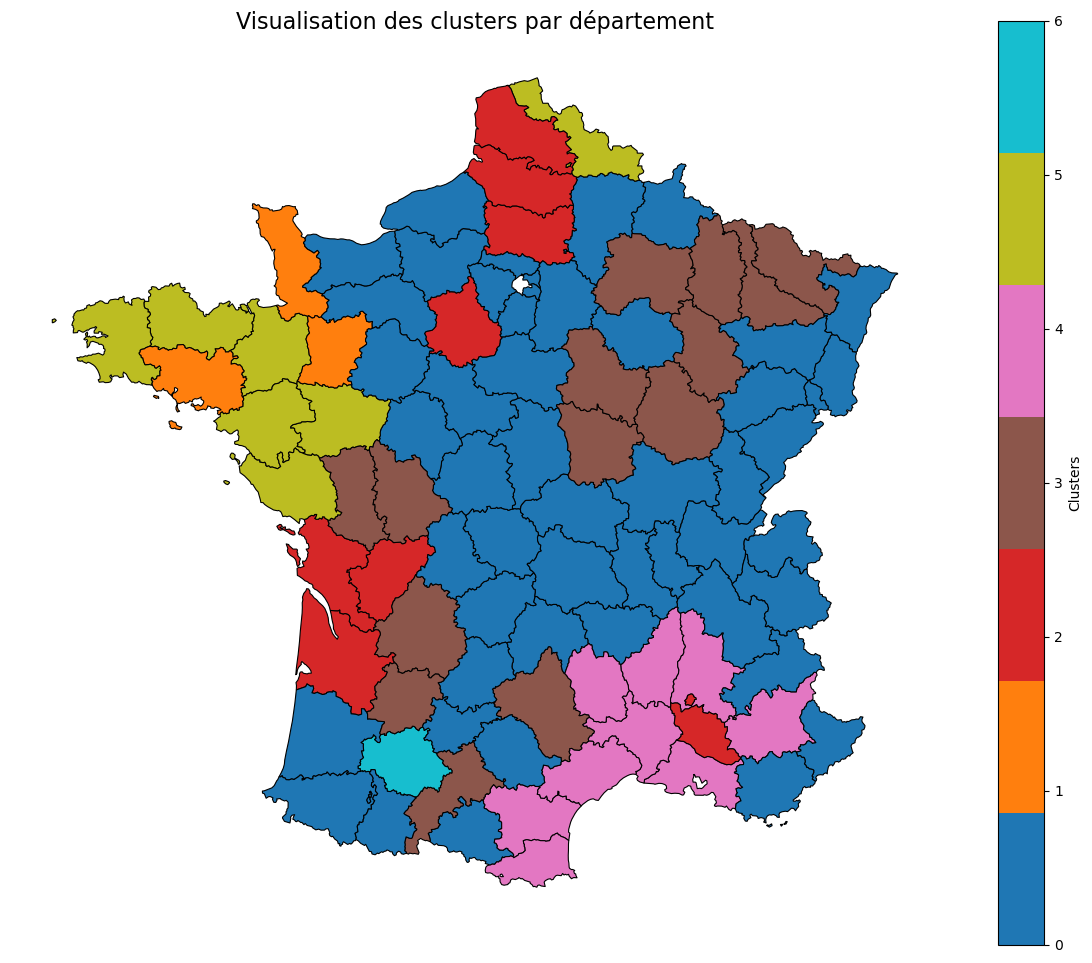

In [91]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Palette de couleurs pour les clusters
colormap = cm.get_cmap('tab10', df_aggregated['cluster'].nunique())

# Tracer la carte
fig, ax = plt.subplots(figsize=(15, 12))
gdf_map.plot(
    column='cluster',                 # Colonne des clusters
    cmap=colormap,                   # Palette de couleurs
    linewidth=0.8,                   # Épaisseur des bordures
    ax=ax,                           # Ajouter au subplot
    edgecolor='black',               # Couleur des bordures
    legend=True,                     # Ajouter une légende
    legend_kwds={'label': "Clusters"}  # Ajouter un titre à la légende
)

# Ajouter un titre à la carte
ax.set_title("Visualisation des clusters par département", fontsize=16)
ax.axis('off')  # Désactiver les axes
plt.show()


### Analyse des Clusters K-Means et Ratio de Parcelles Bio

#### Objectif
L'objectif était d'analyser les départements français en fonction de plusieurs critères :
- **Surface des parcelles bio**.
- **Évolution des ventes de pesticides entre 2018 et 2022**.
- **Types de cultures (grp_culture)**.
- **Proportion de parcelles bio par département**.

Pour cela, un algorithme de clustering K-Means a été utilisé pour regrouper les départements en 7 clusters distincts, et les résultats ont été visualisés géographiquement et analytiquement.

---

#### Résultats Principaux

##### 1. **Répartition Géographique des Clusters**
- La carte montre une répartition des clusters par département. Les départements proches géographiquement ont souvent des similarités dans leur profil bio-agricole.
- Certains départements se démarquent (notamment dans le sud-est et l’ouest), probablement à cause d’une forte proportion de certaines cultures ou des variations marquées dans les ventes de pesticides.

##### 2. **Analyse des Moyennes par Cluster**
Les caractéristiques moyennes des clusters révèlent des différences marquées entre les groupes :
- **Cluster 0 :**
  - Surface bio relativement faible.
  - Ratio de parcelles bio moyen, mais variation modérée dans les ventes de pesticides.
  - Présence de cultures diverses, sans forte dominance.
- **Cluster 1 :**
  - Grande surface bio, avec des variations importantes dans les ventes de pesticides.
  - Forte contribution des prairies temporaires et permanentes.
- **Cluster 2 :**
  - Surface bio faible à modérée.
  - Variations significatives des ventes de pesticides sur la période.
  - Importance notable de certaines cultures comme le tournesol et les autres oléagineux.
- **Cluster 3 :**
  - Cluster homogène avec des surfaces bio modérées.
  - Contributeur important pour des cultures comme le blé tendre.
- **Cluster 4 :**
  - Départements avec des surfaces bio supérieures à la moyenne.
  - Participation importante des prairies permanentes et des fruits à coque.
  - Variations modérées dans les ventes de pesticides.
- **Cluster 5 :**
  - Départements avec une forte proportion de surfaces bio.
  - Dominance de certaines cultures comme les prairies temporaires et les autres céréales.
  - Variations relativement stables des ventes de pesticides.
- **Cluster 6 :**
  - Département atypique avec une surface bio extrêmement élevée et de fortes variations dans les ventes de pesticides.

##### 3. **Contributions des Variables**
Les composantes principales issues du PCA indiquent que :
- **Surface bio** et **variations des ventes de pesticides** (notamment en 2018 et 2022) sont des contributeurs majeurs à la première composante (PC1).
- Les types de cultures spécifiques (e.g., prairies, blé tendre, autres oléagineux) jouent un rôle important dans la deuxième composante (PC2).

---

#### Ratio des Parcelles Bio
La carte des proportions de parcelles bio par département confirme que certains départements de l'ouest (notamment en Bretagne) et du sud-est (région Rhône-Alpes et Provence-Alpes-Côte d'Azur) affichent des ratios significativement plus élevés. Ces départements appartiennent en majorité à des clusters bien définis (e.g., clusters 1 et 6).

---

#### Conclusions et Recommandations
1. **Hétérogénéité régionale :**
   - Les résultats mettent en évidence une hétérogénéité marquée entre les départements, due aux spécificités régionales (type de cultures, pratiques agricoles, etc.).
   - Les clusters révèlent des groupes distincts d’activité agricole bio.

2. **Focus sur les départements atypiques :**
   - Les départements dans les clusters 1 et 6 méritent une attention particulière, car ils représentent des cas extrêmes en termes de surface bio ou de variations de pesticides.

3. **Valorisation des données :**
   - Ces clusters peuvent être utilisés pour orienter des politiques publiques agricoles, par exemple en ciblant les départements avec des pratiques particulièrement efficaces ou problématiques.




